In [8]:
# 1. instalasi library
!pip install imblearn

# 2. import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer, recall_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# 3. memuat data
kolom_nama = [
    'id', 'age', 'gender', 'education', 'country', 'ethnicity',
    'nscore', 'escore', 'oscore', 'ascore', 'cscore', 'impulsiveness', 'ss',
    'alcohol', 'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc',
    'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalhighs', 'lsd',
    'meth', 'mushrooms', 'nicotine', 'semer', 'vsa'
]
df = pd.read_csv('drug_consumption.data', header=None, names=kolom_nama)

# 4. definisi model
models = {
    "naive bayes": GaussianNB(),
    "decision tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42, kernel='rbf')
}

In [9]:
# 1. seleksi fitur dan binerisasi target
fitur_psikometri = ['age', 'gender', 'education', 'country', 'ethnicity',
                    'nscore', 'escore', 'oscore', 'ascore', 'cscore',
                    'impulsiveness', 'ss']
df_bersih = df[fitur_psikometri + ['cannabis']].copy()

def binerisasi_cannabis(label):
    return 0 if label == 'CL0' else 1
df_bersih['target'] = df_bersih['cannabis'].apply(binerisasi_cannabis)

X = df_bersih.drop(['cannabis', 'target'], axis=1)
y = df_bersih['target']

# 2. menangani data hilang dan konversi numerik
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X = X.fillna(X.mean())

fitur_nama = X.columns.tolist()

# 3. scaling dan SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_scaled, y.values)

print(f"proporsi kelas setelah SMOTE:\n{pd.Series(y_smote).value_counts()}")

proporsi kelas setelah SMOTE:
0    1472
1    1472
Name: count, dtype: int64


In [11]:
f1_scorer = make_scorer(f1_score)
recall_scorer = make_scorer(recall_score)
hasil_cv = {}

print("hasil rata-rata 5-fold cross-validation:")

for nama, model in models.items():
    try:
        f1_mean = np.mean(cross_val_score(model, X_smote, y_smote, cv=5, scoring=f1_scorer, n_jobs=-1))
        recall_mean = np.mean(cross_val_score(model, X_smote, y_smote, cv=5, scoring=recall_scorer, n_jobs=-1))

        hasil_cv[nama] = {'F1-score': f1_mean, 'recall': recall_mean}

        print(f"model {nama}: F1-score: {f1_mean:.4f} | recall: {recall_mean:.4f}")

    except Exception as e:
        print(f"gagal mengevaluasi model {nama}: {e}")

df_cv = pd.DataFrame(hasil_cv).T

hasil rata-rata 5-fold cross-validation:
model naive bayes: F1-score: 0.7575 | recall: 0.7186
model decision tree: F1-score: 0.8200 | recall: 0.8090
model SVM: F1-score: 0.7983 | recall: 0.7600


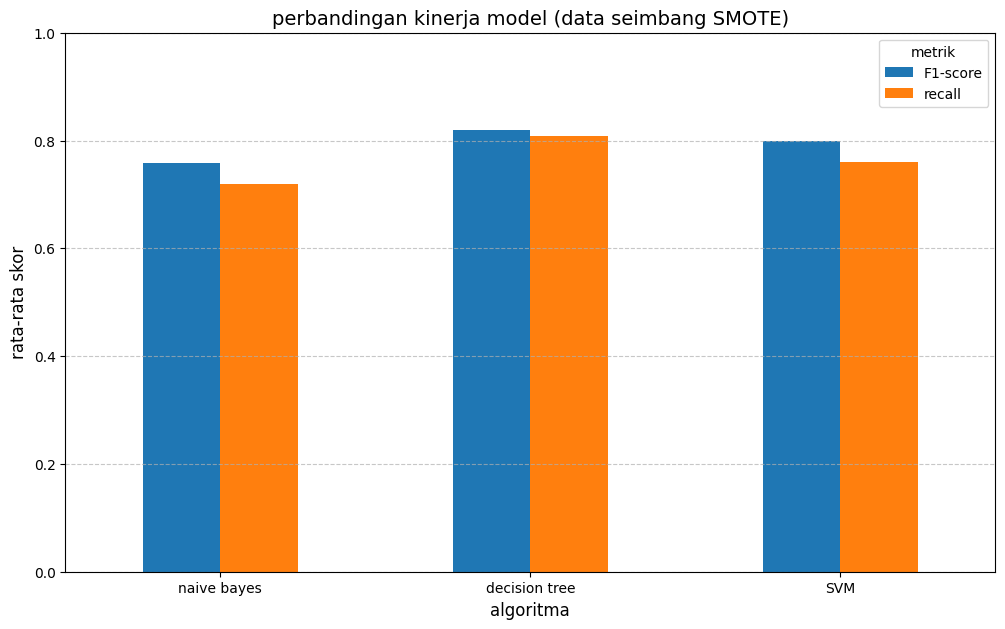

model terbaik berdasarkan F1-score adalah: decision tree


In [14]:
plt.figure(figsize=(12, 7))
df_cv.plot(kind='bar', ax=plt.gca(), rot=0)
plt.title('perbandingan kinerja model (data seimbang SMOTE)', fontsize=14)
plt.xlabel('algoritma', fontsize=12)
plt.ylabel('rata-rata skor', fontsize=12)
plt.ylim(0.0, 1.0)
plt.legend(title='metrik')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

model_terbaik = df_cv['F1-score'].idxmax()
print(f"model terbaik berdasarkan F1-score adalah: {model_terbaik}")


--- peringkat kepentingan faktor psikometri ---
        fitur  kepentingan
      country     0.270467
           ss     0.147466
       cscore     0.102083
       oscore     0.080582
       escore     0.070232
       ascore     0.069465
       nscore     0.060077
    education     0.057987
          age     0.051383
impulsiveness     0.040276
    ethnicity     0.036978
       gender     0.013004


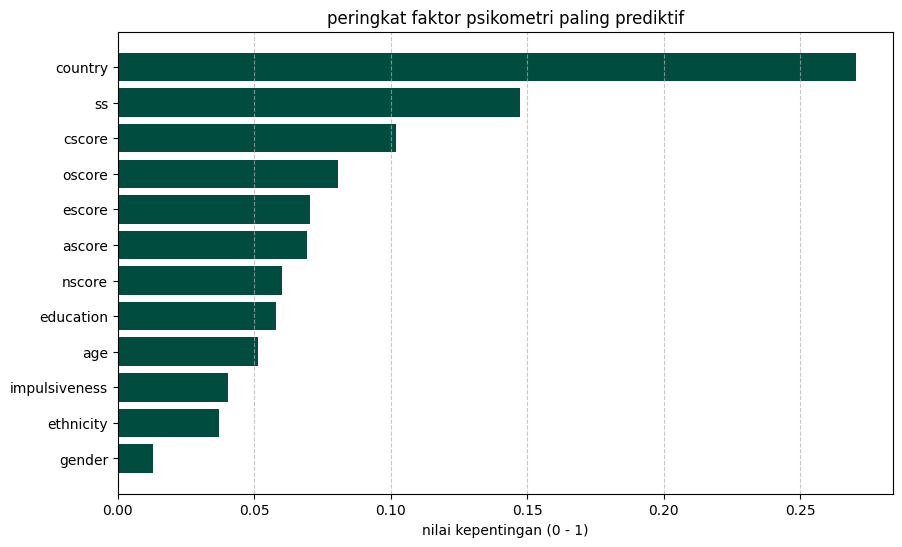

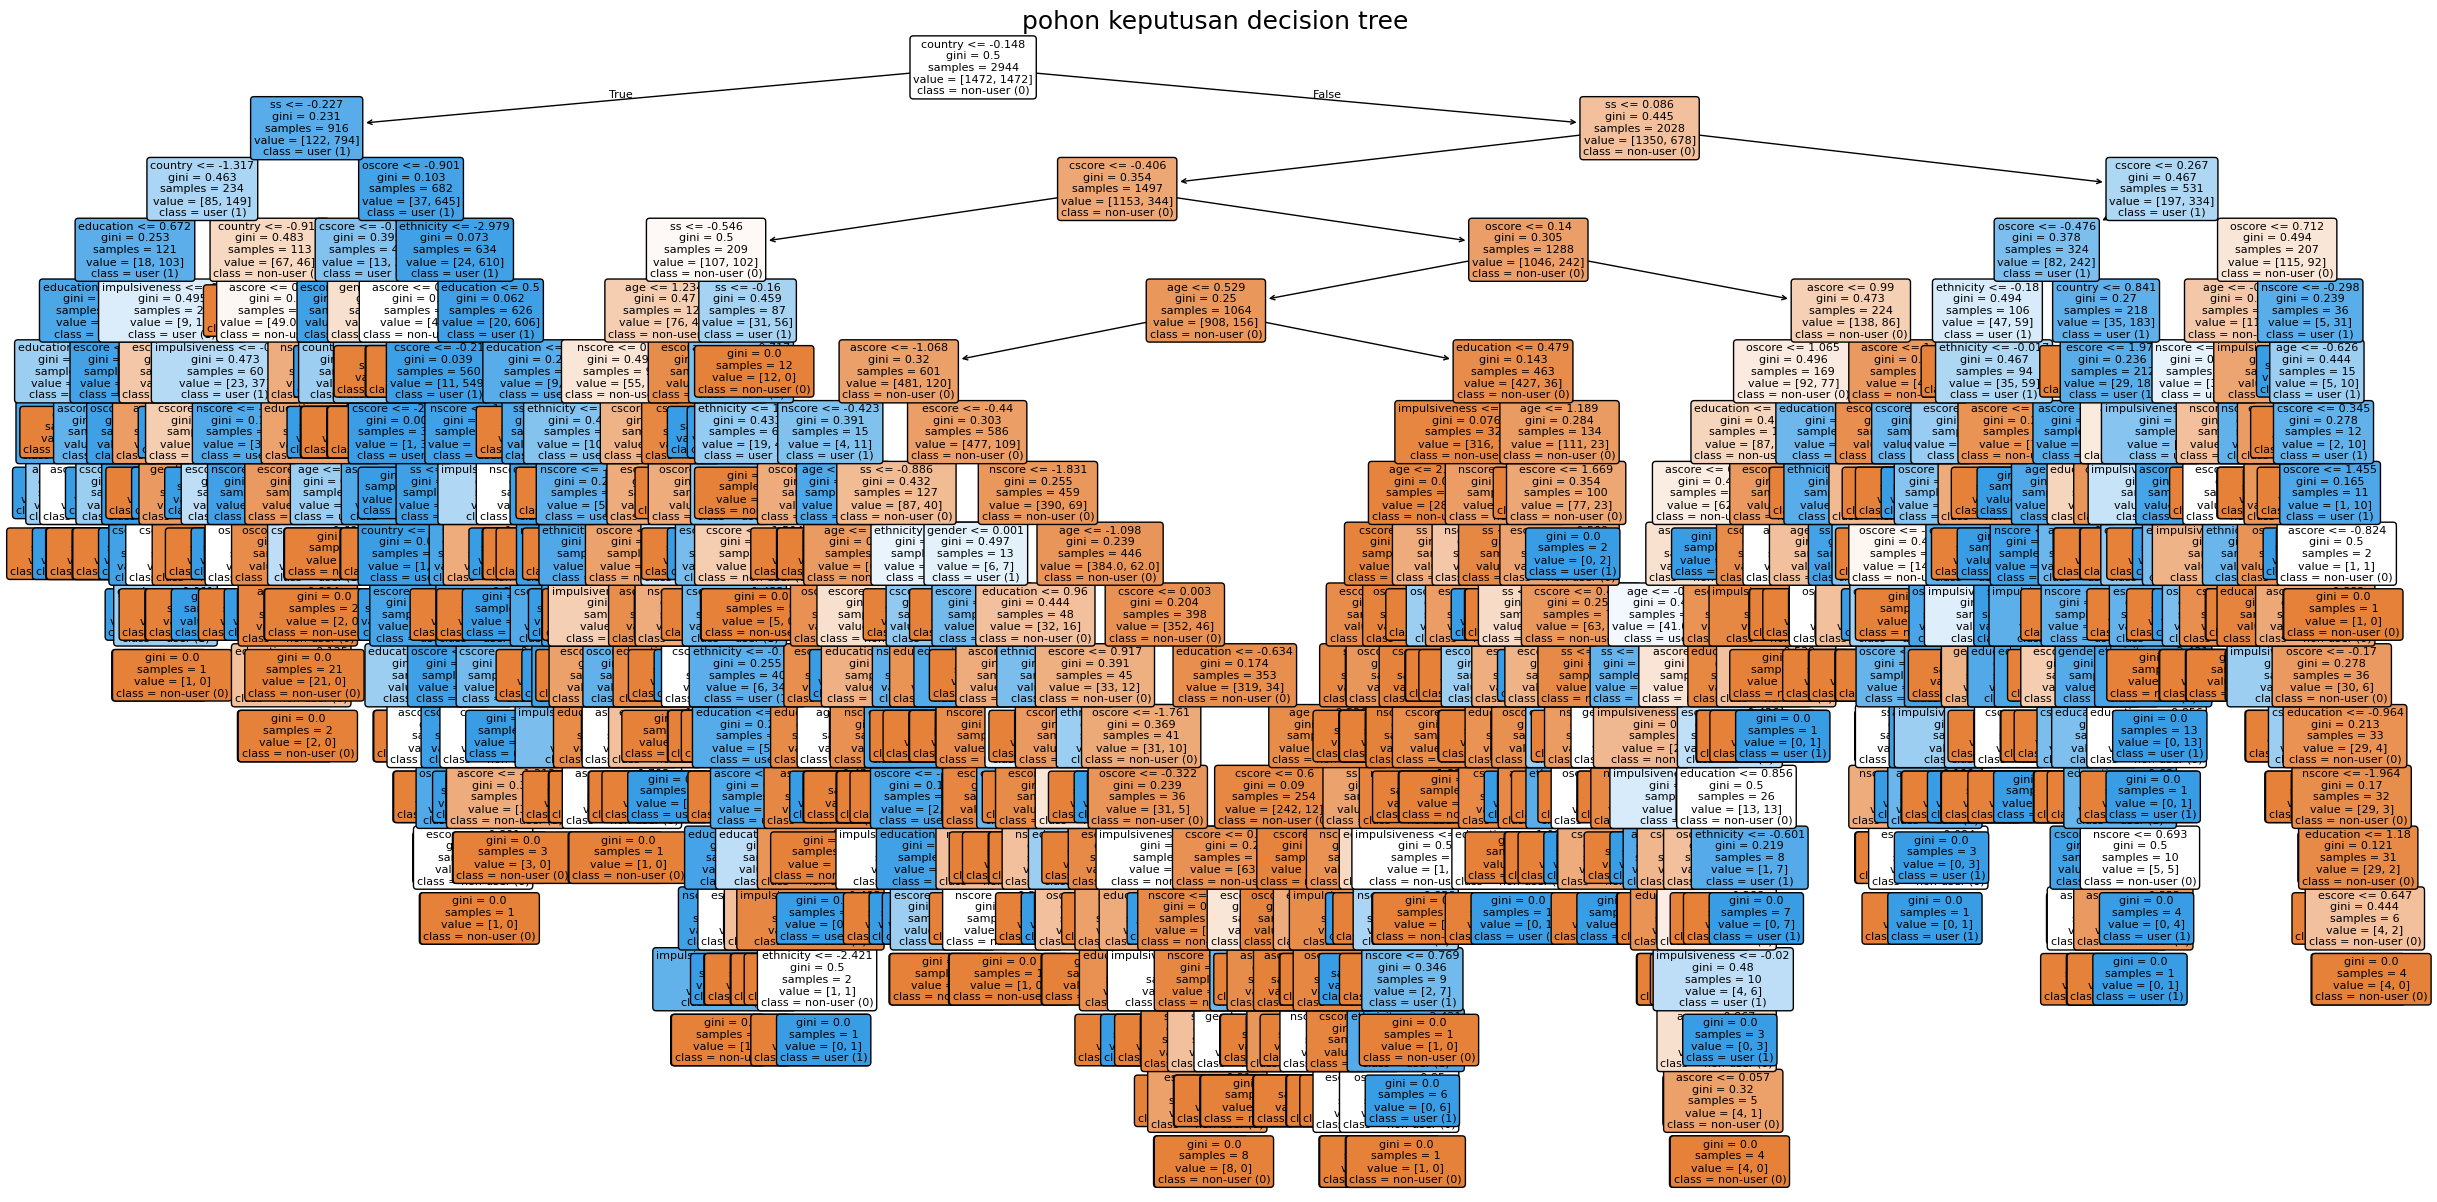

In [15]:
# 1. melatih decision tree pada data seimbang
dt_model = models["decision tree"]
dt_model.fit(X_smote, y_smote)

# 2. peringkat kepentingan fitur
df_importansi = pd.DataFrame({
    'fitur': fitur_nama,
    'kepentingan': dt_model.feature_importances_
}).sort_values(by='kepentingan', ascending=False)

print("\n--- peringkat kepentingan faktor psikometri ---")
print(df_importansi.to_string(index=False))

# 3. visualisasi kepentingan fitur
plt.figure(figsize=(10, 6))
plt.barh(df_importansi['fitur'], df_importansi['kepentingan'], color='#004d40')
plt.xlabel('nilai kepentingan (0 - 1)')
plt.title('peringkat faktor psikometri paling prediktif')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# 4. visualisasi pohon keputusan
plt.figure(figsize=(30, 15))
plot_tree(dt_model,
          feature_names=fitur_nama,
          class_names=['non-user (0)', 'user (1)'],
          filled=True,
          rounded=True,
          fontsize=8)
plt.title("pohon keputusan decision tree", fontsize=18)
plt.show()